В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, root_mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

F1-score: 0.64
ROC AUC: 0.88


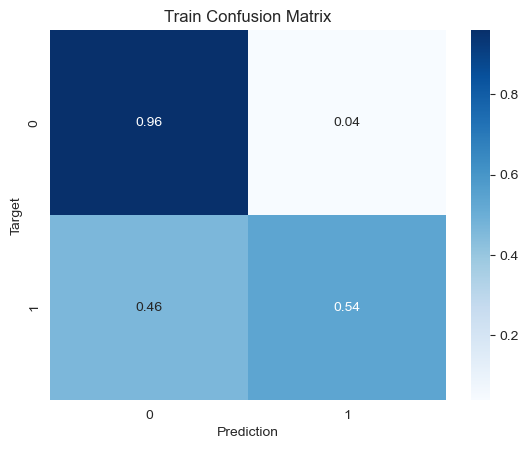

F1-score: 0.64
ROC AUC: 0.88


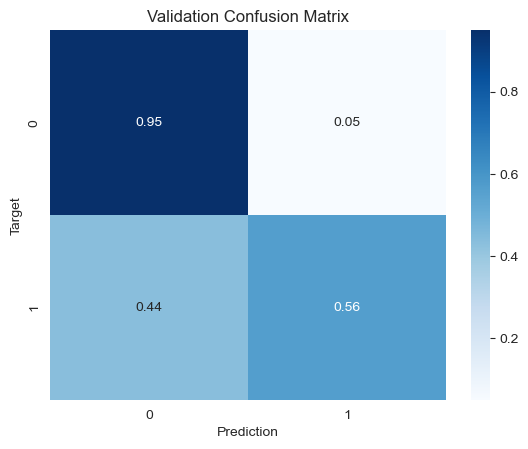

['log_reg.joblib']

In [89]:
# index column id in dataset
bank_df = pd.read_csv('/Users/macbook/Desktop/machine_learning_course/train.csv', index_col=0)

# train and validation subsets
# use stratify
train_df, val_df = train_test_split(bank_df, test_size=0.2, random_state=42, stratify=bank_df['Exited'])

# я дропала колонки У попередній д/р., відрізняється від розв'язку, який у вас. Залишила поки так
target_col = 'Exited'
drop_cols = ['id', 'CustomerId', 'Surname', target_col]
input_cols = train_df.columns.difference(drop_cols).tolist()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

classifier = LogisticRegression(solver='liblinear')

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier ),
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    # predictions 0/1
    preds = model_pipeline.predict(inputs)
    # for ROC
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    print(f"F1-score: {f1_score(targets, preds):.2f}")

    fpr, tpr, _ = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.2f}")

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds, probs

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds, val_probs = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

F1-score: 0.70
ROC AUC: 0.92


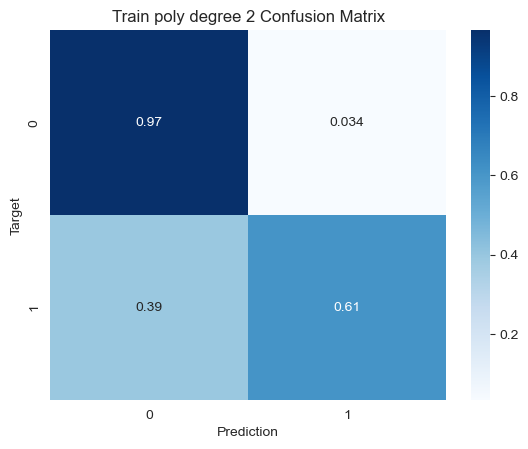

F1-score: 0.69
ROC AUC: 0.92


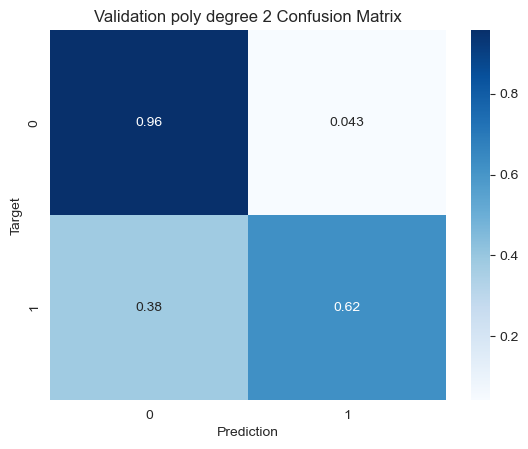

In [90]:
# polynomial features degree = 2
numeric_transformer_poly2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# new preprocessor
preprocessor_poly2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

classifier = LogisticRegression(solver='liblinear')

# new pipeline
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly2),
    ('classifier', classifier),
])

#train
model_pipeline_poly2.fit(train_inputs, train_targets)


train_preds, train_probs = predict_and_plot(model_pipeline_poly2, train_inputs, train_targets, 'Train poly degree 2')
val_preds, val_probs = predict_and_plot(model_pipeline_poly2, val_inputs, val_targets, 'Validation poly degree 2')


Висновок: додавання поліноміальних ознак до степеня 2 покращило якість моделі. ROC AUC був 0.88, а став 0.92.
F1-score теж покращився з 0.64 до 0.69. Модель не перенавчилась, добре генералізує, адже невелика різниця між тренувальними та валідаційними результатами. Модель дуже хороша.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

F1-score: 0.74
ROC AUC: 0.93


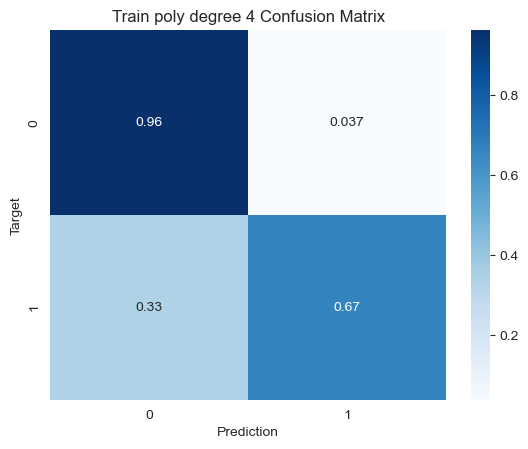

F1-score: 0.72
ROC AUC: 0.93


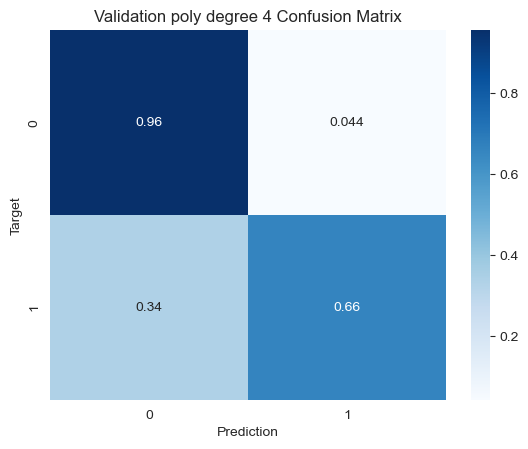

In [91]:
# polynomial features degree = 4
numeric_transformer_poly4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree = 4, include_bias=False)),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# new preprocessor
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

classifier = LogisticRegression(solver='liblinear')

# new pipeline
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', classifier),
])

#train
model_pipeline_poly4.fit(train_inputs, train_targets)

train_preds, train_probs = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train poly degree 4')
val_preds, val_probs = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation poly degree 4')

In [92]:
test_df = pd.read_csv("test.csv")
test_probs = model_pipeline_poly2.predict_proba(test_df)[:, 1]
submission = pd.read_csv('sample_submission.csv')
submission['Exited'] = test_probs
submission.to_csv('submission_pol2.csv', index=False)
pd.Series(test_pred).value_counts()

0.0    8381
1.0    1619
Name: count, dtype: int64

In [93]:
submission['Exited'].head()

0    0.095173
1    0.028299
2    0.112330
3    0.308881
4    0.033901
Name: Exited, dtype: float64

In [94]:
os.listdir()

['HW_2_1_Аналіз_ознак_для_побудови_лінійної_регресії.ipynb',
 'EDA.ipynb',
 'HW_2_1_Матриці_і_вектори_(вступ_до_лін_алгебри).ipynb',
 'submission_log_reg.csv',
 'train_targets.parquet',
 'stat.ipynb',
 'EDA',
 'linear_regression_one_feature.ipynb',
 '2_Лінійна_регресія (1).ipynb',
 'EDA_Solutions.ipynb',
 'application_data.csv',
 'hwnp.ipynb',
 'medical-charges.csv',
 'HW_2_2_Поліноміальні_ознаки_Pipelines.ipynb',
 'linear_reg_one_feature.ipynb',
 'HW_1_1_Основи_статистики_Solution.ipynb',
 'Untitled.ipynb',
 'hwpd_tips.ipynb',
 'test.csv',
 'log_reg_pipeline_code.py',
 'log_reg.joblib',
 'zet_test_hw.ipynb',
 'tips.csv',
 'submission_pol2.csv',
 'Titanic-Dataset.csv',
 'regression_data.csv',
 'eda_hw.ipynb',
 'functions_derivatives.ipynb',
 'test_inputs.parquet',
 'hw5.ipynb',
 '1.ipynb',
 'hw1.ipynb',
 'train_inputs.parquet',
 '.virtual_documents',
 'Лінійна_регресія_від_багатьох_змінних.ipynb',
 'val_inputs.parquet',
 'hw3.ipynb',
 'train.csv',
 '.ipynb_checkpoints',
 'HW_2_2_Л

Висновок: додавання поліноміальних ознак до степеня 4 ще більше покращило якість моделі, різниця незначна, але є. ROC AUC став 0.93.
F1-score теж покращився до 0.72. Модель не перенавчилась, добре генералізує, адже невелика різниця між тренувальними та валідаційними результатами. Модель теж дуже хороша. Можливо доцільніше використати degree = 2, щоб не ускладнювати модель.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [95]:
reg_data_df = pd.read_csv('/Users/macbook/Desktop/machine_learning_course/regression_data.csv')
reg_data_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [96]:
X = reg_data_df.drop(['target'], axis=1)
y = reg_data_df[['target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
def train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_train_lin = lin_reg.predict(X_train)
    y_pred_val_lin = lin_reg.predict(X_val)

    poly_reg_features = PolynomialFeatures(degree = degree)
    X_train_poly = poly_reg_features.fit_transform(X_train)
    X_val_poly = poly_reg_features.fit_transform(X_val)

    poly_reg_lin = LinearRegression()
    poly_reg_lin.fit(X_train_poly, y_train)
    y_pred_train_poly = poly_reg_lin.predict(X_train_poly)
    y_pred_val_poly = poly_reg_lin.predict(X_val_poly)

    rmse_lin_train = root_mean_squared_error(y_train, y_pred_train_lin)
    rmse_poly_train = root_mean_squared_error(y_train, y_pred_train_poly)
    rmse_lin_val = root_mean_squared_error(y_val, y_pred_val_lin)
    rmse_pol_val = root_mean_squared_error(y_val, y_pred_val_poly)

    print(f"Train RMSE for Linear Regression: {rmse_lin_train:.3f}")
    print(f"Test RMSE for Linear Regression: {rmse_lin_val:.3f}")
    print("------------------------------------------------------------------")
    print(f"Train RMSE for Polynomial Regression: {rmse_poly_train:.3f}")
    print(f"Test RMSE for Polynomial Regression: {rmse_pol_val:.3f}")

degree = 5
train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree)


Train RMSE for Linear Regression: 1.066
Test RMSE for Linear Regression: 0.883
------------------------------------------------------------------
Train RMSE for Polynomial Regression: 0.000
Test RMSE for Polynomial Regression: 29.433


Висновок: Лінійна регресія - коректна, модель добре узагальнює дані.
Поліноміальна регресія - невдала. Ступінь 5 призвела до перенавчання, модель не генералізує. Пробувала ступінь 2 - вийшов хороший результат.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [98]:
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5),
]


In [99]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = root_mean_squared_error(y_train, y_train_pred)
    val_metrics = root_mean_squared_error(y_val, y_val_pred)

    return dict(train = train_metrics, val = val_metrics)

In [100]:
poly_features = PolynomialFeatures(degree = 20)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)


In [101]:
X_train_poly.shape

(103, 53130)

Погана форма - даних має бути більше, ніж ознак, інакше буде перенавчання.

In [102]:
for model in models:
    model.fit(X_train_poly, y_train)
    eval_results = evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.004971637822348612, 'val': 102877.90229968181}

Ridge(): {'train': 32.58280341900272, 'val': 9048.13886860568}

Ridge(alpha=2): {'train': 32.58280341900272, 'val': 9048.13886860568}

Lasso(): {'train': 2.313505449570354, 'val': 68.31879121877043}

ElasticNet(): {'train': 10.159852342199374, 'val': 1526.8209205681153}

ElasticNet(alpha=0.5): {'train': 7.7417320342064295, 'val': 1083.4024678459548}



Висновок: поліноміальні ознаки у степіні 20 дуже перевищили кількість даних, це призвело до перенавчання у Лінійній Регресії. Лассо (L1) з усіх варіантів найкраще генералізувала, тому що у нас вийшло багато ознак, Лассо робить автоматичний відбір ознак. Для покращення моделі треба зменшити степінь полінома, підібрати альфа-параметр.